## Core

In [ ]:
#| default_exp magic_cell

In [ ]:
#| hide
# %load_ext autoreload
# %autoreload 2

In [ ]:
#| hide
from dotenv import load_dotenv
import os

In [ ]:
#| hide
load_dotenv();

## Friend**LL**y

In [ ]:
#| export

system_prompt="""
You are Claude, a very knowledgeable and intelligent research assistant.
Fulfill simple requests right away.
For more complicated tasks, use <thought> to plan your actions.

When appropriate, use Jupyter notebook. It has python 3.10+ and many packages installed.
Use <code> to add a new code cell at the end of your message. You will receive all its output on the next turn.

Prefer short cells that can be tested quickly.

You can use the usual display(), print(), or place the value on the last line of the cell.
Make sure to not add anything after that value, as it won't be returned if it's not on the last line.
Only output a result once with one method.
Avid using .show() and close matplot figures before the end of the cell - use an explicit display().

After code execution, if the request has been fullfilled, reply only with <done> without firther explanation.
The user will ask follow-up questions if needed. Only do only what they asked for.
You should also end your text with <done> if there is no need to run code.

To show an example in python without running the code, use
```python
python code here
```

For example:
User: Calculate square root of pi
Assistant: <code>
import math
math.sqrt(math.pi)
</code>
User: <stdio>1.7724538509055159<stdio>
Assistant: <done>

User: Display cat.jpg and describe wat you see.
Assistant: <thought>I can use the PIL library for this.</thought><code>
from PIL import Image
Image.open("cat.jpg")
</code>
User: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=128x127>
User: <image message>
Assistant: *describes the cat in the image*

When writing code, use advanced python features. Assume all packages are installed.
Import modules before using them.
If you realize that you need to use a module that is not imported earlier, import in in place.
"""


In [ ]:
from friendlly.utils.notebook import detect_environment

In [ ]:
detect_environment()

'jupyterlab'

In [ ]:
#| export

import sys
import base64
import json
from typing import List, Dict, Tuple
import textwrap
import warnings

from friendlly.utils.notebook import (
    nbclassic_patch_kernel,
    nbclassic_add_cell,
    nbclassic_update_cell,
    nbclassic_render_cell,
    nbclassic_execute_cell,
    nbclassic_delete_cell,
    nbclassic_get_index,
    update_code_self,
    update_code_next,
    detect_environment,
    vscode_get_cells
    )


from friendlly.utils.misc import nict, safe_int
from friendlly.utils.capture_trace import strip_junk, SaveTraceback
from friendlly.utils.capture_display import PassthroughCapturer, svg_to_png
from friendlly.utils.capture_io import TeeIO
import claudette
from claudette import text_msg, img_msg, mk_msg


from IPython import get_ipython
from IPython.display import display, clear_output, Markdown, Javascript

In [ ]:
#| export
# Patch the Jupyter nbclassic kernel.
if detect_environment() == "nbclassic":
    nbclassic_patch_kernel()


In [ ]:
#| export

def display_data_to_messages(dsp):
    plain_text = dsp.get("text/plain")
    text = list(filter(lambda x:x[1], [
        ("text-html", dsp.get("text/html")),
        ("latex", dsp.get("text/latex")),
        ("markdown", dsp.get("text/markdown")),
        ("json", dsp.get("application/json")),
        ("js", dsp.get("application/javascript"))
    ]))

    images = list(filter(lambda x:x, [ dsp.get("image/png"), dsp.get("image/jpeg") ]))
    svg = dsp.get("image/svg+xml")
    if svg: images.append(svg_to_png(svg, 256))

    messages = [f"<{t[0]}>{t[1]}</{t[0]}>" for t in text]

    if not len(messages):
        messages = [plain_text]

    claudette_msgs = [text_msg(m) for m in messages]
    if images:
        image = images[0] # Grab only one image
        if isinstance(image, str):
            image = base64.b64decode(image)
        claudette_msgs.append(img_msg(image))

    return claudette_msgs

def parse_cell_line(line):
    num_cells, is_friendlly, is_reply, is_config = 0, False, False, False
    if line.lstrip('# \t').rstrip().startswith("%%fr"):
        is_friendlly = True
        args = line.split()
        for arg in args[1:]:
            if "+" in arg: num_cells = safe_int(arg[1:])
            if arg == "reply": is_reply = True
            if arg == "config" : is_config = True

    return num_cells, is_friendlly, is_reply, is_config

def parse_above_cell(cell):
    assert "source" in cell
    if cell.cell_type != "code":
        assert not "outputs" in cell or not len(cell.outputs), "Got a non-code cell with outputs??"
        return False, False, text_msg(cell.source), []

    num_cells = 0
    is_reply = False
    is_friendlly = False
    code_blk = None
    output_blks = []

    lines = cell.source.strip().splitlines()
    if lines:
        num_cells, is_friendlly, is_reply, _ = parse_cell_line(lines[0])

        # Remove the cell magic
        if is_friendlly:
            lines = lines[1:]
        code_text = "\n".join(lines)

        outputs = cell.get("outputs", [])
        for o in outputs:
            if o.output_type == "stream":
                output_blks.append(text_msg(f"<{o.name}>{o.text}</{o.name}>"))
            if o.output_type in ("display_data", "execute_result"):
                # We produce a lot of empty JS outputs when running the chat, and they don't get
                # cleaned up in time. Let's just ignore empty js objects.
                if "application/javascript" not in o.data or o.data["application/javascript"]:
                    output_blks += display_data_to_messages(o.data)
            if o.output_type == "error":
                output_blks.append(text_msg("<error>" + strip_junk("\n".join(o.traceback)) + "</error>"))



        return is_friendlly, is_reply, code_text, output_blks
    return False, False, None, []

In [ ]:
#| export

def cells_to_messages(cells):
    messages = []


    # We found the first %%fr message (request from user).
    # This means that we treat further cells (markdown and code without %%fr) as assistant-generated.
    user_message_found = False
    for cell in cells:
        cell_friendlly, cell_reply, code_text, output_blks = parse_above_cell(cell)

        if code_text:
            # If the cell is marked with %%fr reply, or we found the user request above.
            if cell_reply:       role="assistant"  # Messages has '%%fr reply'
            elif cell_friendlly: role="user" # Message has %%fr without 'reply'
            else:                role="assistant" if user_message_found else "user" # It's not an %%fr cell.

            # We found an %%fr cell that is not a reply - means it's a user message!
            if cell_friendlly and not cell_reply: user_message_found=True

            # Assistant code gets wrapped into tags, user code gets wrapped into ```
            # Markdown is passed as is.
            if role == "assistant" and cell.cell_type == "code":
                code_text = f"<code>{code_text}</code>"
            elif role == "user":
                code_text = f"```\n{code_text}\n```"

            messages.append(mk_msg([code_text], role=role))

        # Outputs for both user and assistant code cells are always user messages.
        if output_blks:
            messages.append(mk_msg(output_blks, role="user"))

    return [nict(m) for m in messages]

In [ ]:
#| export

def merge_messages(msgs):

    # first, merge by role
    role_messages = []
    prev_role = None

    for m in msgs:
        if prev_role == m.role: role_messages[-1].content += m.content
        else:                   role_messages.append(m)
        prev_role = m.role

    # Then, for assistant, also coalesce text messages together
    for m in role_messages:
        merged_content = []
        for c in m.content:
            if c.type == "text" and merged_content and merged_content[-1].type == "text":
                merged_content[-1].text += ("\n" + c.text)
            else: merged_content.append(c)
        m.content = merged_content
    return role_messages


In [ ]:
#| export

def make_cell_from_captured(source:str, res, stdout:str, stderr:str, displays, tracebacks):
    ip = get_ipython()
    cell = nict()
    cell.metadata  = {}
    cell.cell_type = "code"
    cell.source    = source
    cell.outputs   = []
    if stdout: cell.outputs.append(nict(output_type="stream", name="stdout", text=stdout))
    if stderr: cell.outputs.append(nict(output_type="stream", name="stderr", text=stderr))
    for d in displays:
        cell.outputs.append(nict(output_type="display_data", data=d))
    if res.result:
        formatted, _ = ip.display_formatter.format(res.result)
        cell.outputs.append(nict(output_type="execute_result", data=formatted))
    for t in tracebacks:
        cell.outputs.append(nict(t, output_type="error"))

    return cell

In [ ]:
#| export

config = nict(
    environment=detect_environment(),
    autorun=detect_environment() == "nbclassic",
    md_cells=detect_environment() == "nbclassic",
    comment_after_run=True,
    api_key=None,
    model="claude-3-5-sonnet-20240620",
    system_prompt=system_prompt,
)

def strip_comments(cell: str):
    lines = cell.splitlines()
    return "\n".join([ l.split("#")[0] for l in lines ]).strip()

def handle_config(cell):
    global config
    ip = get_ipython()

    cell = strip_comments(cell)
    # If the cell was empty, show the config
    if not cell:
        cell = "\n".join([f'{k}="""{v}"""' if isinstance(v, str) else f"{k}={v}" for k, v in config.items()])
        update_code_self("%%fr config\n" + cell)
    else:
        new_config = {}
        # Code, globals, locals. We want the locals
        exec(cell, {}, new_config)
        config.update(new_config)

        if config.autorun and config.environment != "nbclassic":
            warnings.warn("Autorun is only supported in nbclassic environment at the moment.")

        if config.md_cells and config.environment != "nbclassic":
            warnings.warn("Inserting Markdown cells is only supported in nbclassic environment at the moment.")
        if config.api_key:
            warnings.warn("FIY It's safer to set ANTHROPIC_API_KEY in the environment or even better .env file and use dotenv package to load it.")

In [ ]:
#| export

class CellChat():
    def __init__(self, config):
        self.config = config
        self.display_handle = None # Used when config.md_cell=False
        self.history = []
        self.client = claudette.Client(model=self.config.model)

    def update_markdown(self, text):
        # md_cells means we output the text as markdown cells.
        # Otherwise, we display them.
        if self.config.md_cells and self.idx is not None:
            if not self.added_md_cell:
                nbclassic_add_cell(self.idx+1, "markdown")
                self.added_md_cell = True
            nbclassic_update_cell(self.idx+1, text)
            nbclassic_render_cell(self.idx+1)
        else:
            data = {"text/markdown": text, "config/message_type": "assistant"}
            if self.display_handle:
                self.display_handle.update(data, raw=True)
            else:
                self.display_handle = display(data, raw=True, display_id=True)

    def delete_markdown(self):
        if self.config.md_cells and self.added_md_cell:
            nbclassic_delete_cell(self.idx+1)
            self.added_md_cell = False
        elif self.display_handle:
            # Empty JS cells ge cleaned up after the cell is executed.
            self.display_handle.update(Javascript(""))

    def update_code(self, code):
        # We have an markdown cell before the code cell. This can only be done with JS in nbclassic.
        if self.added_md_cell and self.idx is not None:
            if not self.added_code_cell:
                nbclassic_add_cell(self.idx+2, "code")
                self.added_code_cell = True

            nbclassic_update_cell(self.idx+2, code)
        else:
            # No markdown cell before core - we can use the native ipython method.
            update_code_next(code)

    def go(self, idx,  num_above, messages):
        self.idx = idx
        self.added_md_cell = self.added_code_cell = False
        self.thought_display_id = None
        self.history.append(messages)

        tokens = []
        try:
            md_reply = ""
            md_updated = False
            code_reply = ""
            code_updated = False
            thought = ""

            state = "md"

            r = self.client(messages,
                            sp=self.config.system_prompt,
                            stream=True,
                            stop=["</code>", "<done>"])
            for token in r:
                tokens.append(token)
#                 print(state, f"'{token}'", f"'{code_reply}'", f"'{md_reply}'")

                if state == "md":
                    md_reply += token
                    md_updated = True

                    if "<code>" in md_reply:
                        md_reply, code_reply = md_reply.split("<code>")
                        code_updated = True
                        state = "code"

                    if "<thought>" in md_reply:
                        md_reply_body, thought = md_reply.split("<thought>")
                        state = "thought"

                elif state == "thought":
                    thought += token
                    md_tail = ""
                    md_updated = True

                    def combine_md_reply(body, thought, tail=""):
                        return f'{body}<details><summary style="display: list-item">🧠</summary>{thought}</details>{tail}'

                    if "</thought>" in thought:
                        thought, md_tail = thought.split("</thought>")
                        state = "md"
                    md_reply = combine_md_reply(md_reply_body, thought, md_tail)

                else: #code
                    code_reply += token
                    code_updated = True

                if md_updated:
                    md_updated = False
                    if md_reply.strip():
                        self.update_markdown(md_reply.strip())
                    else:
                        self.delete_markdown()

                if code_updated:
                    code_updated = False
                    prefix = f"%%fr +{num_above + 2 if self.added_md_cell else 1} reply\n"
                    self.update_code(prefix + code_reply.strip())

            if self.client.stop_reason == "stop_sequence":
                tokens += self.client.stop_sequence
            self.history.append(claudette.mk_msg("".join(tokens), role="assistant"))

            code_cell_idx = None if self.idx is None else self.idx + int(self.added_code_cell) + int(self.added_md_cell)
            return code_cell_idx, md_reply

        except BaseException as e:
            raise e
#             display(Markdown(f"🚫 {repr(e)}"))
#             get_ipython().showtraceback()

In [ ]:
#| export

chat = None
def fr_cell(line=None, cell=None):
    global chat
    global config
    chat = CellChat(config=config)

    num_cells, is_friendlly, is_reply, is_config = 0, False, False, False
    idx = None
    ip = get_ipython()
    prev_messages = []
    if line:
        # line comes with magic already stripped.
        num_cells, is_friendlly, is_reply, is_config = parse_cell_line("%%fr " + line)
        if num_cells and not is_config:
            assert is_friendlly, "Called on a cell without %%fr?"
            header = nict(ip.parent_header)


            cells_above = []
            if config.environment == "nbclassic":
                if "cells_above" not in header.content:
                    warnings.warn("Jupyter did not send any of the above cells")
                else:
                    cells_above = header.content.cells_above;
            elif config.environment == "vscode":
                idx, cells_above = vscode_get_cells(num_cells)
            else:
                warnings.warn("Only nbclassic and vscode environments can access previous cells")
            prev_messages = cells_to_messages(cells_above)

    if is_config:
        handle_config(cell)
        return

    if idx is None:
        if config.environment == "nbclassic":
            idx = nbclassic_get_index()
        elif config.environment == "vscode":
            idx, _ = vscode_get_cells(0)

    # If it's a folllow-up message, we should first run the current cell and collect its outputs,
    # then pass the outputs to the chat as user messages for further generation.

    if is_reply:
        disp_capturer = PassthroughCapturer()
        disp_capturer.start()

        sys.stdout = stdout = TeeIO(sys.stdout)
        sys.stderr = stderr = TeeIO(sys.stderr)

        traceback = SaveTraceback(ip._showtraceback)
        traceback.register()

        # This runs the current cell, and we should capture all its outputs.
        res = ip.run_cell(cell)

        traceback.unregister()
        disp_capturer.stop()
        sys.stdout = stdout._stream
        sys.stderr = stderr._stream

        new_cell = make_cell_from_captured(source="%%fr " + line + "\n" + cell,
                                           res=res,
                                           stdout=stdout.getvalue(),
                                           stderr=stderr.getvalue(),
                                           displays=disp_capturer.get_outputs(),
                                           tracebacks=traceback.tracebacks)
        prev_messages += cells_to_messages([new_cell])

    else:
        prev_messages.append(nict(mk_msg(cell, role="user")))

    prev_messages = merge_messages(prev_messages)
    # Assistant message can't be the first in the conversation, nor can it be the last.
    if prev_messages:
        if prev_messages[0].role == "assistant":
            prev_messages.insert(0, nict(mk_msg("(Beginning of the conversation truncated)", role="user")))
        if prev_messages[-1].role == "assistant":
            prev_messages.append(nict(mk_msg("Continue", role="user")))

    code_idx, md_text = chat.go(idx, num_cells, prev_messages)

    # If it's a reply cell, comment out the magic. Otherwise, comment out the
    # whole cell, as it's likely plain text, and not valid Python.
    # This makes it easy to re-run the ai-generated notebook manually without triggering the ai.
    cell_text = f"%%fr {line}\n{cell.strip()}".splitlines()
    if is_reply:
        cell_text[0] = "# " + cell_text[0]
    elif config.comment_after_run:
        cell_text = ["# " + l for l in cell_text]

    update_code_self("\n".join(cell_text))

    # This schedules the execution of the next cell.
    if config.autorun and idx is not None and code_idx != idx:
        nbclassic_execute_cell(code_idx)


    # We've created a lot of invisible JS display outputs. Unfortunaely I don't think there is a way
    # to clear them without removing everying.
    clear_output()

    if is_reply:
        # Re-display the outputs.
        for d in disp_capturer.raw_outputs:
            ip.display_pub.publish(**d)
        if stdout.getvalue(): print(stdout.getvalue())
        if stderr.getvalue(): print(stderr.getvalue(), file=sys.stderr)
        for tb in traceback.tracebacks:
            ip._showtraceback(tb.ename, tb.evalue, tb.traceback)

    if md_text: display(Markdown(md_text))
    if is_reply: return res.result


In [ ]:
#| eval: false
get_ipython().register_magic_function(fr_cell, 'cell', magic_name='fr')
nbclassic_patch_kernel()

<IPython.core.display.Javascript object>

In [ ]:
%%fr config
environment="""jupyterlab"""
autorun=False
md_cells=False
comment_after_run=True
api_key=None
model="""claude-3-5-sonnet-20240620"""
system_prompt="""
You are Claude, a very knowledgeable and intelligent research assistant.
Fulfill simple requests right away.
For more complicated tasks, use <thought> to plan your actions.

When appropriate, use Jupyter notebook. It has python 3.10+ and many packages installed.
Use <code> to add a new code cell at the end of your message. You will receive all its output on the next turn.

Prefer short cells that can be tested quickly.

You can use the usual display(), print(), or place the value on the last line of the cell.
Make sure to not add anything after that value, as it won't be returned if it's not on the last line.
Only output a result once with one method.
Avid using .show() and close matplot figures before the end of the cell - use an explicit display().

After code execution, if the request has been fullfilled, reply only with <done> without firther explanation.
The user will ask follow-up questions if needed. Only do only what they asked for.
You should also end your text with <done> if there is no need to run code.

To show an example in python without running the code, use
```python
python code here
```

For example:
User: Calculate square root of pi
Assistant: <code>
import math
math.sqrt(math.pi)
</code>
User: <stdio>1.7724538509055159<stdio>
Assistant: <done>

User: Display cat.jpg and describe wat you see.
Assistant: <thought>I can use the PIL library for this.</thought><code>
from PIL import Image
Image.open("cat.jpg")
</code>
User: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=128x127>
User: <image message>
Assistant: *describes the cat in the image*

When writing code, use advanced python features. Assume all packages are installed.
Import modules before using them.
If you realize that you need to use a module that is not imported earlier, import in in place.
"""

In [ ]:
# %%fr 
# Download an image of a cat, resize it to 200 on the long side and show it. Ten describe it briefly in the style of Jeremy Howard.

Certainly! Let's download an image of a cat, resize it, display it, and then I'll describe it in Jeremy Howard's style.



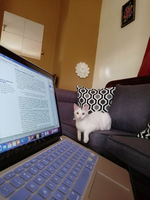

The image shows a white cat sitting on what appears to be a dark-colored couch or sofa. The cat is looking directly at the camera with bright, alert eyes. In the foreground, we can see part of a laptop or computer keyboard, suggesting this might be someone's home office or living room setup. The background shows some wall decor, including what looks like a clock or picture frame. The lighting in the room gives it a warm, cozy atmosphere. The cat appears comfortable and at ease in its environment, demonstrating the typical relaxed posture of a contented house cat.



In [ ]:
# %%fr +1 reply
import requests
from PIL import Image
from io import BytesIO

# Download an image of a cat
url = "https://cataas.com/cat"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Resize the image to 200 on the long side
long_side = max(img.size)
scale_factor = 200 / long_side
new_size = tuple(int(dim * scale_factor) for dim in img.size)
resized_img = img.resize(new_size, Image.LANCZOS)

# Display the resized image
display(resized_img)